In [ ]:
# to access files from google drive.

from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import keras.utils
from keras import applications
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, f1_score
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import os
import cv2
from sklearn import preprocessing

In [ ]:
# Preparing Dataset

x, y = [], []

for disease in os.listdir('drive/MyDrive/PlantDiseaseDatasetNew/'):
  for img in os.listdir('drive/MyDrive/PlantDiseaseDatasetNew/'+ disease):
    x.append(cv2.resize(cv2.imread('drive/MyDrive/PlantDiseaseDatasetNew/'+ disease + '/' + img),(250,250)))
    y.append(disease)

x, y = np.array(x), np.array(y)

print(x.shape,y.shape)


(5634, 250, 250, 3) (5634,)


In [ ]:
# Encoding Class Labels 

le = preprocessing.LabelEncoder()
le.fit(['Apple___Apple_scab',
 'Apple___Black_rot',
 'Apple___healthy',
 'Grape___Black_rot',
 'Grape___Esca_(Black_Measles)',
 'Grape___healthy',
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 'Potato___Early_blight',
 'Potato___healthy',
 'Potato___Late_blight',
 'Strawberry___healthy',
 'Strawberry___Leaf_scorch'])
y_ = le.transform(y)

In [ ]:
# Splitting Dataset into Train, Test and Validation sets

X_train, X_test, y_train, y_test = train_test_split(x, y_, test_size=0.10, random_state = 3)

X_train, X_CV, y_train, y_CV = train_test_split(X_train, y_train, test_size=0.10, random_state=3)

In [ ]:
# Normalizing 

X_train = X_train/255
X_test = X_test/255
X_CV = X_CV/255

In [ ]:
# Converting class labels into binary class matrices

y_train = keras.utils.to_categorical(y_train,num_classes=12)
y_test = keras.utils.to_categorical(y_test,num_classes=12)
y_CV = keras.utils.to_categorical(y_CV,num_classes=12)

In [ ]:
# Preparing the model

res = applications.InceptionResNetV2(input_shape=(250,250,3), weights='imagenet', include_top=False)
res.trainable = False
print('Resnet pre trained model is loaded ....')
print(res.summary())

model = Sequential([res,
                    Flatten(),
                    Dense(150,activation='tanh'),
                    Dropout(0.5),
                    BatchNormalization(),
                    Dense(12,activation='softmax')
                    ])

219062272/219055592 [==============================] - 1s 0us/step
Resnet pre trained model is loaded ....
Model: "inception_resnet_v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 250, 250, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 124, 124, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 124, 124, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 124, 124, 32) 0           batch_n

In [ ]:
# Defining Callback
early_stopping_callback = keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=3)

In [ ]:
# Training model

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=1e-4),
              metrics=['accuracy'])

model.fit(X_train, y_train, batch_size=512, epochs=20, validation_data=(X_CV,y_CV),callbacks=[early_stopping_callback])


Epoch 1/20
9/9 [==============================] - 49s 3s/step - loss: 2.0810 - accuracy: 0.3713 - val_loss: 0.6481 - val_accuracy: 0.7751
Epoch 2/20
9/9 [==============================] - 15s 2s/step - loss: 0.6161 - accuracy: 0.7967 - val_loss: 0.3223 - val_accuracy: 0.8974
Epoch 3/20
9/9 [==============================] - 15s 2s/step - loss: 0.3592 - accuracy: 0.8850 - val_loss: 0.2621 - val_accuracy: 0.9270
Epoch 4/20
9/9 [==============================] - 15s 2s/step - loss: 0.2511 - accuracy: 0.9265 - val_loss: 0.2040 - val_accuracy: 0.9408
Epoch 5/20
9/9 [==============================] - 15s 2s/step - loss: 0.1731 - accuracy: 0.9549 - val_loss: 0.1865 - val_accuracy: 0.9428
Epoch 6/20
9/9 [==============================] - 15s 2s/step - loss: 0.1402 - accuracy: 0.9686 - val_loss: 0.1589 - val_accuracy: 0.9467
Epoch 7/20
9/9 [==============================] - 15s 2s/step - loss: 0.1089 - accuracy: 0.9803 - val_loss: 0.1612 - val_accuracy: 0.9527
Epoch 8/20
9/9 [==================

In [ ]:
print("Final accuracy on test set : ", 100*model.evaluate(X_test, y_test)[1], "%")

18/18 [==============================] - 3s 137ms/step - loss: 0.1193 - accuracy: 0.9645
Final accuracy on test set :  96.45389914512634 %


In [ ]:
# COHEN KAPPA SCORE ON TEST SET:-
prediction = np.argmax(model.predict(X_test),axis=1)

In [ ]:
print("Cohen Kappa score is : ", cohen_kappa_score(prediction,np.argmax(y_test,axis=1)))

Cohen Kappa score is :  0.9612505625195379


In [ ]:
# F1 SCORE ON TEST SET :-
print("F1 score is : ", f1_score(prediction,np.argmax(y_test,axis=1), average = 'macro'))

F1 score is :  0.964920928466991


Confusion Matrix is : 


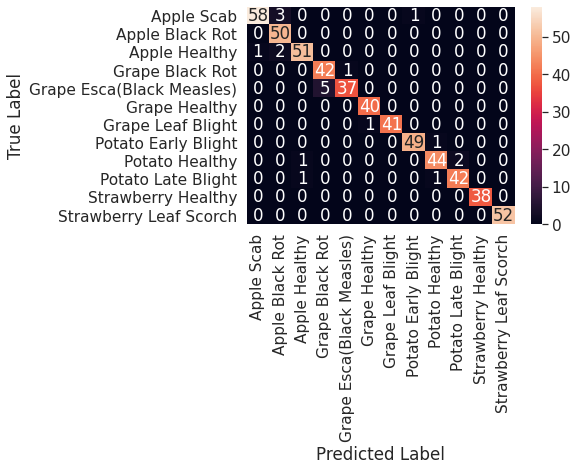

In [ ]:
# CONFUSION MATRIX
conf_matrix = confusion_matrix(np.argmax(y_test,axis=1),prediction)

print("Confusion Matrix is : ")

df = pd.DataFrame(conf_matrix,columns=['Apple Scab',
 'Apple Black Rot',
 'Apple Healthy',
 'Grape Black Rot',
 'Grape Esca(Black Measles)',
 'Grape Healthy',
 'Grape Leaf Blight',
 'Potato Early Blight',
 'Potato Healthy',
 'Potato Late Blight',
 'Strawberry Healthy',
 'Strawberry Leaf Scorch'],index = ['Apple Scab',
 'Apple Black Rot',
 'Apple Healthy',
 'Grape Black Rot',
 'Grape Esca(Black Measles)',
 'Grape Healthy',
 'Grape Leaf Blight',
 'Potato Early Blight',
 'Potato Healthy',
 'Potato Late Blight',
 'Strawberry Healthy',
 'Strawberry Leaf Scorch'] )
sn.set(font_scale=1.4)
sn.heatmap(df,annot=True,fmt='d')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()
